In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Path

In [156]:
# dataset path
X = "/content/drive/MyDrive/Colab Notebooks/road_segmentation_ideal/training/input/"
Y = "/content/drive/MyDrive/Colab Notebooks/road_segmentation_ideal/training/output/"

Import libraries 

In [157]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
import cv2
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import normalize
from sklearn.model_selection import train_test_split

loading Images- preprocessing

In [158]:
img = [] 
masks = [] 

In [159]:
def load_images(img = img,masks=masks, imgPath = None, maskPath = None, shape = 256):
  for filename in listdir(imgPath):
    pixels_X=load_img(imgPath+filename)
    pixels_X=cv2.resize(np.float32(pixels_X), (shape, shape))
    img.append(pixels_X)
    pixels_Y=load_img(maskPath+filename)
    pixels_Y=cv2.resize(np.float32(pixels_Y), (shape, shape))
    masks.append(pixels_Y[:,:,0])
  return img,masks

In [160]:
img,masks = load_images(img = img,masks=masks,imgPath=X,maskPath = Y,shape = 256)

In [161]:
img = np.array(img) / 255.
masks = np.array(masks) 

Spliting the data in training and test set

In [162]:
X_train, X_test, y_train, y_test = train_test_split(img,masks, test_size = 0.20, random_state = 0)

In [163]:
X_train.shape

(643, 256, 256, 3)

In [164]:
X_test.shape

(161, 256, 256, 3)

Displaying data loaded by our function

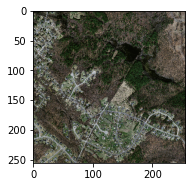

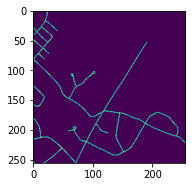

In [169]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(X_train[1])
plt.show()
plt.subplot(1,2,2)
plt.imshow(y_train[1])
plt.show()

Define unet model

In [170]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def roadextract(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

Model Checkpoint

In [171]:
earlystoping = tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss')

Instantiating  model

In [172]:
inputs = tf.keras.layers.Input((256, 256, 3))
roadextract = roadextract(inputs, droupouts= 0.07)
roadextract.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

plot unet model

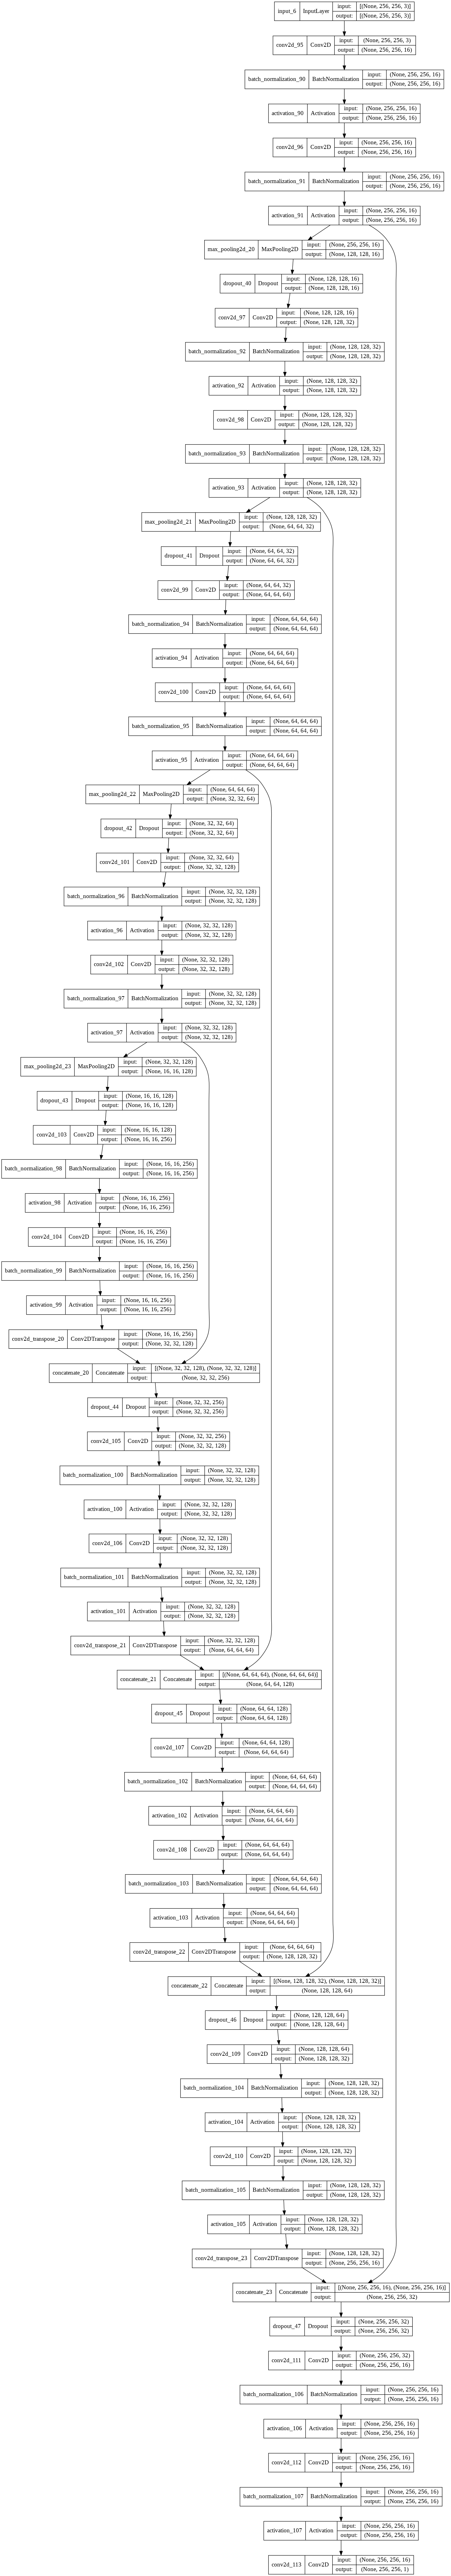

In [173]:
from keras.utils.vis_utils import plot_model
plot_model(roadextract, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

Train the Model

In [174]:
roadextract_training = roadextract.fit(np.array(X_train),np.array(y_train),batch_size = 16, validation_data=(np.array(X_test), np.array(y_test)),  epochs = 10, verbose = 1,callbacks=earlystoping)

Epoch 1/10
41/41 [==============================] - 23s 476ms/step - loss: -31.1390 - accuracy: 0.5868 - val_loss: 41.8615 - val_accuracy: 0.9319
Epoch 2/10
41/41 [==============================] - 16s 403ms/step - loss: -69.9123 - accuracy: 0.4808 - val_loss: 108.9616 - val_accuracy: 0.9271
Epoch 3/10
41/41 [==============================] - 17s 405ms/step - loss: -97.4202 - accuracy: 0.2347 - val_loss: 49.2532 - val_accuracy: 0.8761


Evaluate model on test data

In [175]:
_, acc = roadextract.evaluate(np.array(X_test), np.array(y_test))
print("Accuracy of standard Model is = ", (acc * 100.0), "%")


6/6 [==============================] - 1s 216ms/step - loss: 49.2532 - accuracy: 0.8761
Accuracy of standard Model is =  87.60952949523926 %


Plot the training and validation accuracy and loss at each epoch

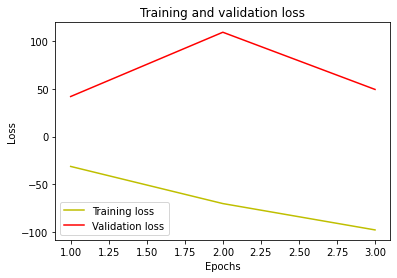

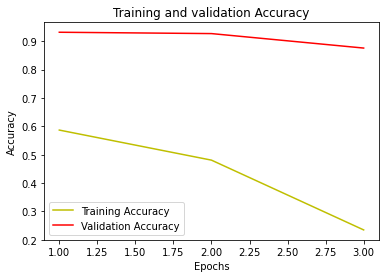

In [176]:
loss = roadextract_training.history['loss']
val_loss = roadextract_training.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = roadextract_training.history['accuracy']
val_acc = roadextract_training.history['val_accuracy']


plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


IOU

In [177]:
#IOU
y_pred=roadextract.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test.flatten(),y_pred_thresholded.flatten())
union = np.logical_or(y_test.flatten(),y_pred_thresholded.flatten())
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.13424346543711124


In [178]:
def predict (val_img,val_masks,model, shape = 256):
    ## getting and proccessing val data
    val_img = val_img[0:12]
    val_masks = val_masks[0:12]
    #mask = mask[0:16]
    
    imgProc = val_img [0:12]
    imgProc = np.array(val_img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, val_masks


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Satellite image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    

In [179]:
predicted, actuals, masks = predict(img,masks, roadextract)

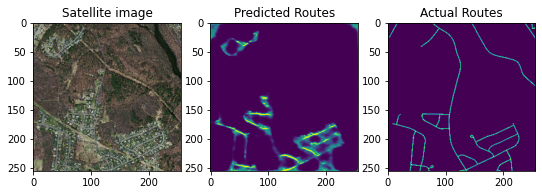

In [180]:
Plotter(actuals[1], predicted[1][:,:,0], masks[1])

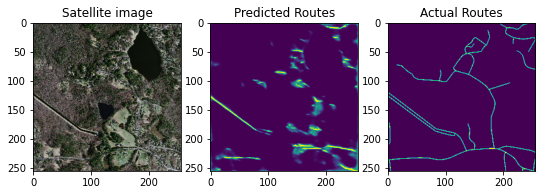

In [181]:
Plotter(actuals[2], predicted[2][:,:,0], masks[2])

In [94]:
roadextract.save('RoadExtractor.h5')

In [182]:
#Validation dataset
# dataset path
X_val = "/content/drive/MyDrive/Colab Notebooks/road_segmentation_ideal/testing/input/"
Y_val = "/content/drive/MyDrive/Colab Notebooks/road_segmentation_ideal/testing/output/"

In [185]:
val_img = [] 
val_masks = [] 

In [60]:
ValidationObj = {'img' : [],
           'mask' : []
          }


In [186]:
def load_images_val(val_img = None,val_masks=None, imgPath = None, maskPath = None, shape = 256):
  for filename in listdir(imgPath):
    pixels_X=load_img(imgPath+filename)
    pixels_X=cv2.resize(np.float32(pixels_X), (shape, shape))
    val_img.append(pixels_X)
    pixels_Y=load_img(maskPath+filename)
    pixels_Y=cv2.resize(np.float32(pixels_Y), (shape, shape))
    val_masks.append(pixels_Y[:,:,0])
  return val_img,val_masks

In [187]:
val_img,val_masks = load_images_val(val_img = val_img,val_masks=val_masks,imgPath=X_val,maskPath = Y_val,shape = 256)

In [188]:
val_img = np.array(val_img) / 255.
val_masks = np.array(val_masks) 

In [172]:
#ValidationObj = load_images_srx(ValidationObj,imgPath=X_val,maskPath = Y_val,shape = 256)

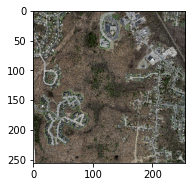

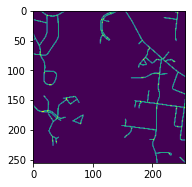

In [189]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(val_img[1])
plt.show()
plt.subplot(1,2,2)
plt.imshow(val_masks[1])
plt.show()

In [190]:
predicted_Val, actuals, masks = predict(val_img, val_masks,roadextract)

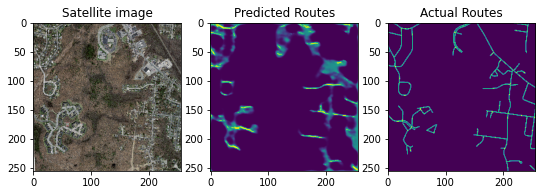

In [191]:
Plotter(actuals[1], predicted_Val[1][:,:,0], masks[1])

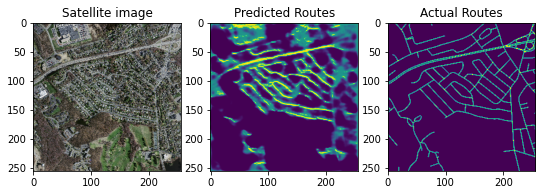

In [192]:
Plotter(actuals[2], predicted_Val[2][:,:,0], masks[2])